In [6]:
import glob
import pyarrow
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.linear_model import LinearRegression

In [7]:
data_types = ['green', 'yellow']
datasets = {}

for dtype in data_types:
    pattern = f'taxis/*/{dtype}_tripdata_20*-*.parquet'
    files = glob.glob(pattern)
    print(f"Files found for {dtype}: {files}")
    
    if files:
        dfs = [pd.read_parquet(file) for file in files]
        datasets[dtype] = pd.concat(dfs, ignore_index=True)
    else:
        print(f"No files found for {dtype}")

Files found for green: ['taxis\\2024-07\\green_tripdata_2024-07.parquet', 'taxis\\2024-08\\green_tripdata_2024-08.parquet', 'taxis\\2024-09\\green_tripdata_2024-09.parquet', 'taxis\\2024-10\\green_tripdata_2024-10.parquet', 'taxis\\2024-11\\green_tripdata_2024-11.parquet', 'taxis\\2024-12\\green_tripdata_2024-12.parquet', 'taxis\\2025-01\\green_tripdata_2025-01.parquet']
Files found for yellow: ['taxis\\2024-07\\yellow_tripdata_2024-07.parquet', 'taxis\\2024-08\\yellow_tripdata_2024-08.parquet', 'taxis\\2024-09\\yellow_tripdata_2024-09.parquet', 'taxis\\2024-10\\yellow_tripdata_2024-10.parquet', 'taxis\\2024-11\\yellow_tripdata_2024-11.parquet', 'taxis\\2024-12\\yellow_tripdata_2024-12.parquet', 'taxis\\2025-01\\yellow_tripdata_2025-01.parquet']


In [8]:
print(datasets['yellow'])

          VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
0                1  2024-07-01 00:34:56   2024-07-01 00:46:49   
1                2  2024-06-30 23:48:58   2024-07-01 00:28:04   
2                2  2024-07-01 00:23:18   2024-07-01 00:29:51   
3                1  2024-07-01 00:10:33   2024-07-01 00:27:31   
4                1  2024-07-01 00:07:55   2024-07-01 00:34:34   
...            ...                  ...                   ...   
24312848         2  2025-01-31 23:01:48   2025-01-31 23:16:29   
24312849         2  2025-01-31 23:50:29   2025-02-01 00:17:27   
24312850         2  2025-01-31 23:26:59   2025-01-31 23:43:01   
24312851         2  2025-01-31 23:14:34   2025-01-31 23:34:52   
24312852         2  2025-01-31 23:56:42   2025-02-01 00:07:27   

          passenger_count  trip_distance  RatecodeID store_and_fwd_flag  \
0                     1.0           3.20         1.0                  N   
1                     1.0          19.48         2.0                 

In [10]:
event_frames = []

for dtype, df in datasets.items():
    if dtype == 'yellow':
        pickup_col = 'tpep_pickup_datetime'
        dropoff_col = 'tpep_dropoff_datetime'
    elif dtype == 'green':
        pickup_col = 'lpep_pickup_datetime'
        dropoff_col = 'lpep_dropoff_datetime'
    else:
        raise ValueError(f"Unexpected dataset type: {dtype}")
    
    df[pickup_col] = pd.to_datetime(df[pickup_col])
    df[dropoff_col] = pd.to_datetime(df[dropoff_col])
    
    df = df[(df[pickup_col] >= pd.Timestamp('2024-01-01')) &
            (df[pickup_col] <= pd.Timestamp('2025-01-31'))]
    
    pickups = df[[pickup_col, 'PULocationID']].copy()
    pickups = pickups.rename(columns={pickup_col: 'time_interval', 'PULocationID': 'LocationID'})
    pickups['time_interval'] = pickups['time_interval'].dt.floor('10min')
    pickups['count'] = 1 
    
    dropoffs = df[[dropoff_col, 'DOLocationID']].copy()
    dropoffs = dropoffs.rename(columns={dropoff_col: 'time_interval', 'DOLocationID': 'LocationID'})
    dropoffs['time_interval'] = dropoffs['time_interval'].dt.floor('10min')
    dropoffs['count'] = 1 
    
    events = pd.concat([pickups, dropoffs], ignore_index=True)
    event_frames.append(events)

In [11]:
all_events = pd.concat(event_frames, ignore_index=True)
final_df = all_events.groupby(['time_interval', 'LocationID'])['count'].sum().reset_index()
final_df = final_df.sort_values(['time_interval', 'LocationID']).reset_index(drop=True)

In [12]:
print(final_df[:20])

         time_interval  LocationID  count
0  2024-06-30 23:00:00         264      1
1  2024-06-30 23:40:00          68      1
2  2024-06-30 23:40:00         132      1
3  2024-06-30 23:40:00         164      1
4  2024-06-30 23:40:00         230      1
5  2024-06-30 23:50:00          66      1
6  2024-06-30 23:50:00          70      1
7  2024-06-30 23:50:00          88      1
8  2024-06-30 23:50:00         114      1
9  2024-06-30 23:50:00         132      3
10 2024-06-30 23:50:00         163      1
11 2024-06-30 23:50:00         170      1
12 2024-06-30 23:50:00         186      3
13 2024-06-30 23:50:00         237      1
14 2024-06-30 23:50:00         263      1
15 2024-07-01 00:00:00           4      1
16 2024-07-01 00:00:00           7      2
17 2024-07-01 00:00:00          10      2
18 2024-07-01 00:00:00          26      1
19 2024-07-01 00:00:00          41      1


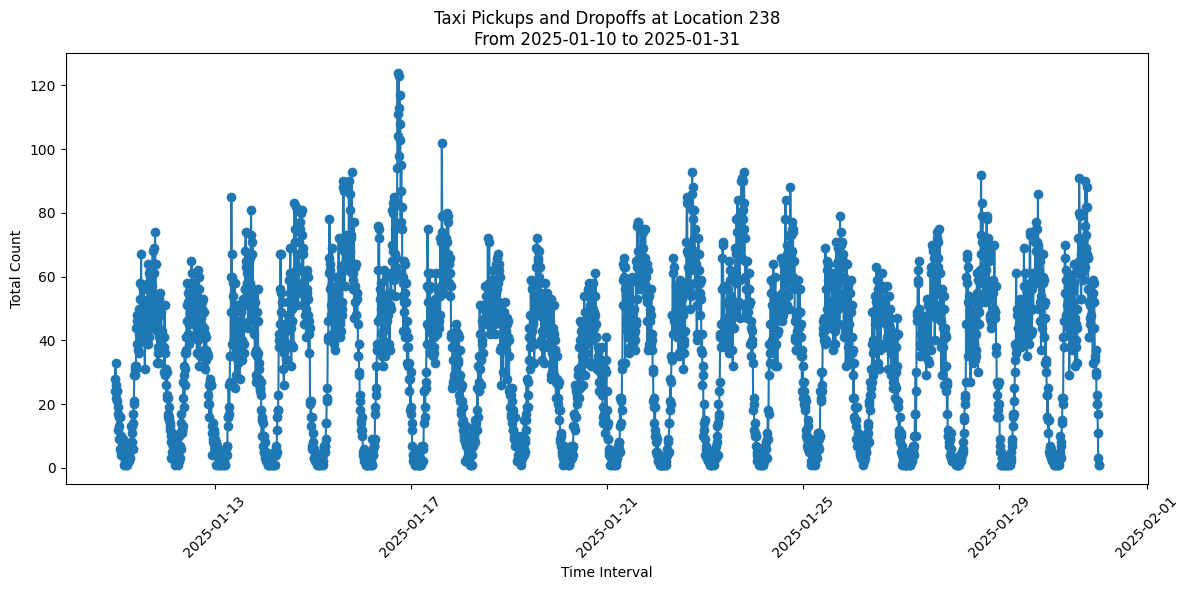

In [13]:
end_time = final_df['time_interval'].max()
start_time = end_time - pd.Timedelta(weeks=3)

locid = 238
loc_week_df = final_df[
    (final_df['LocationID'] == locid) &
    (final_df['time_interval'] >= start_time) &
    (final_df['time_interval'] <= end_time)
]

plt.figure(figsize=(12, 6))
plt.plot(loc_week_df['time_interval'], loc_week_df['count'], marker='o', linestyle='-')
plt.title(f"Taxi Pickups and Dropoffs at Location {locid}\nFrom {start_time.date()} to {end_time.date()}")
plt.xlabel("Time Interval")
plt.ylabel("Total Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
zone_lookup = pd.read_csv('taxi_zone_lookup.csv')
manhattan_zones = zone_lookup[zone_lookup['Borough'] == 'Manhattan']
manhattan_location_ids = manhattan_zones['LocationID'].unique()
final_df = final_df[final_df['LocationID'].isin(manhattan_location_ids)]
print(final_df.head())

        time_interval  LocationID  count
1 2024-06-30 23:40:00          68      1
3 2024-06-30 23:40:00         164      1
4 2024-06-30 23:40:00         230      1
7 2024-06-30 23:50:00          88      1
8 2024-06-30 23:50:00         114      1


In [ ]:
def croston_forecast(series, alpha=0.1):
    series = np.array(series)
    n = len(series)
    nonzero_idx = np.where(series > 0)[0]
    if len(nonzero_idx) == 0:
        return 0 
    a = series[nonzero_idx[0]]  
    p = nonzero_idx[0] + 1  
    last_nonzero = nonzero_idx[0]
    
    for t in range(last_nonzero+1, n):
        if series[t] > 0:
            a = alpha * series[t] + (1 - alpha) * a
            interval = t - last_nonzero
            p = alpha * interval + (1 - alpha) * p
            last_nonzero = t
    return a / p

In [ ]:
forecasts = {}
unique_location_ids = final_df['LocationID'].unique()
forecast_horizon = 3 * 30 * 24 * 6

for loc in unique_location_ids:
    ts_df = final_df[final_df['LocationID'] == loc].copy()
    ts = ts_df.set_index('time_interval')['count']
    
    full_index = pd.date_range(start=ts.index.min(), end=ts.index.max(), freq='10min')
    ts = ts.reindex(full_index, fill_value=0)
    
    try:
        hw_model = ExponentialSmoothing(ts, trend='add', seasonal='add', seasonal_periods=144)
        hw_fit = hw_model.fit(optimized=True)
        hw_forecast = hw_fit.forecast(forecast_horizon)
    except Exception as e:
        print(f"Holt-Winters failed for LocationID {loc} with error: {e}")
        hw_forecast = pd.Series(0, index=pd.date_range(start=ts.index[-1] + pd.Timedelta('10min'),
                                                         periods=forecast_horizon, freq='10min'))

    croston_value = croston_forecast(ts.values, alpha=0.1)
    future_index = pd.date_range(start=ts.index[-1] + pd.Timedelta('10min'),
                                 periods=forecast_horizon, freq='10min')
    croston_forecast_series = pd.Series(croston_value, index=future_index)
    combined_forecast = (hw_forecast + croston_forecast_series) / 2
    
    forecasts[loc] = combined_forecast

    print(loc, " completed")


In [ ]:
print("done")

In [ ]:
print(forecasts[43]) #ts ass

In [15]:
forecast_horizon = 3 * 30 * 24 * 6 

predictions = {}
unique_location_ids = final_df['LocationID'].unique()

for loc in unique_location_ids:
    ts_df = final_df[final_df['LocationID'] == loc].copy()
    ts_series = ts_df.set_index('time_interval')['count']
    
    ts_series = ts_series.asfreq('10min', fill_value=0)
    df = pd.DataFrame({'count': ts_series})
    df['t'] = np.arange(len(df))
    
    df['sin_daily'] = np.sin(2 * np.pi * df['t'] / 144)
    df['cos_daily'] = np.cos(2 * np.pi * df['t'] / 144)
    df['sin_weekly'] = np.sin(2 * np.pi * df['t'] / (144*7))
    df['cos_weekly'] = np.cos(2 * np.pi * df['t'] / (144*7))
    
    X = df[['t', 'sin_daily', 'cos_daily', 'sin_weekly', 'cos_weekly']]
    y = df['count']
    
    model = LinearRegression()
    model.fit(X, y)
    
    last_t = df['t'].iloc[-1]
    future_t = np.arange(last_t + 1, last_t + forecast_horizon + 1)
    
    future_features = pd.DataFrame({
        't': future_t,
        'sin_daily': np.sin(2 * np.pi * future_t / 144),
        'cos_daily': np.cos(2 * np.pi * future_t / 144),
        'sin_weekly': np.sin(2 * np.pi * future_t / (144*7)),
        'cos_weekly': np.cos(2 * np.pi * future_t / (144*7))
    })
    
    future_preds = model.predict(future_features)
    future_preds = np.maximum(0, future_preds)
    
    last_timestamp = df.index[-1]
    future_index = pd.date_range(start=last_timestamp + pd.Timedelta('10min'),
                                 periods=forecast_horizon, freq='10min')
    
    forecast_series = pd.Series(future_preds, index=future_index)
    predictions[loc] = forecast_series


In [16]:
forecast_dfs = []
for loc, forecast_series in predictions.items():
    temp_df = forecast_series.reset_index()
    temp_df.columns = ['time_interval', 'count']
    temp_df['LocationID'] = loc
    forecast_dfs.append(temp_df)

In [17]:
all_forecasts = pd.concat(forecast_dfs, ignore_index=True)

# Optionally, sort by time_interval and LocationID
all_forecasts = all_forecasts.sort_values(['time_interval', 'LocationID']).reset_index(drop=True)

# Concatenate the forecast data with the original data.
# Note: final_df should have the same columns: time_interval, LocationID, count
combined_data = pd.concat([final_df, all_forecasts], ignore_index=True)

# Optionally, sort combined data by time_interval and LocationID
combined_data = combined_data.sort_values(['time_interval', 'LocationID']).reset_index(drop=True)

# Save the combined forecasts to a CSV file
combined_data.to_csv("taxi_pred.csv", index=False)
print("Forecasts saved to taxi_pred.csv")

Forecasts saved to taxi_pred.csv
